## LINK TO GOOGLE DRIVE(DATA+IPYNB): https://drive.google.com/drive/folders/1TWjjQrsCVBKhvx8TEP7pBsZK9zaMsx3i?usp=sharing

In [167]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import re
import matplotlib.image as mpimg

In [168]:
from skimage.feature import graycomatrix , graycomatrix 
from skimage import io, color
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
import random
from PIL import Image

# Accessing Images

To access the images, please provide the location of the main directory where the images are saved.

## Expected Data Structure

The main directory should point to where the 'images' folder is saved. Within the 'images' folder, there should be seven subfolders, each containing images corresponding to a specific class.

### Link to Dataset
[Download Dataset](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification?resource=download)

In this dataset, we have selected images only from the following classes: 'agricultural', 'baseballdiamond', 'beach', 'buildings', 'denseresidential', 'forest', 'harbor'. Therefore, please ensure that these folders are present within the 'images' folder.


# Creating GLCM and SDH Dataset

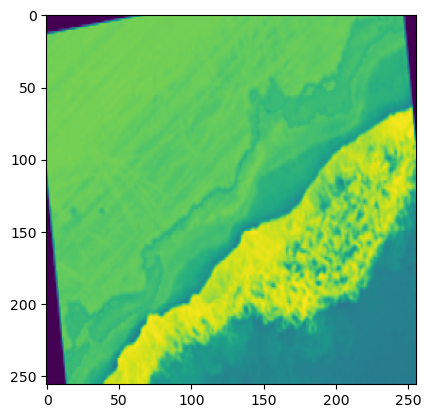

In [169]:
def get_image(k,i):
    main_directory = r'C:\Users\Akshat Kumar\OneDrive - Indian Institute of Technology Bombay\Desktop\Final_Dataset\Images'
    # Get the list of folders inside the 'Images' folder
    folders = os.listdir(main_directory)

    # Define the path to the selected folder
    selected_folder_path = os.path.join(main_directory, folders[k])

    # Get the list of image files in the selected folder
    image_files = os.listdir(selected_folder_path)

    # Define the path to the selected image
    selected_image_path = os.path.join(selected_folder_path, image_files[i])

    # Load the selected image
    rgb_image = Image.open(selected_image_path)

    # Convert the image to grayscale
    grayscale_image = rgb_image.convert('L')

    # Convert the grayscale image to an array
    grayscale_array = np.array(grayscale_image)
    return grayscale_array

plt.imshow(get_image(2,499))

## Calulating The GLCM Features 

In [170]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def calculate_glcm_features(image_label, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    """
    Calculate GLCM features for a given labeled image.
    
    Parameters:
        image_label (2D array): Labeled image.
        distances (list of int, optional): List of pixel pair distances. Default is [5].
        angles (list of float, optional): List of pixel pair angles in radians. Default is [0, np.pi/4, np.pi/2, 3*np.pi/4].
        levels (int, optional): Number of gray levels. Default is 256.
        symmetric (bool, optional): Whether the GLCM is symmetric. Default is True.
        normed (bool, optional): Whether to normalize the GLCM. Default is True.
        
    Returns:
        list: List of GLCM features calculated for the input image.
    """
    # Calculate GLCM
    glcm = graycomatrix(image_label, distances=distances, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
    
    # Define GLCM properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    # Calculate GLCM properties
    glcm_features = np.zeros(len(properties))
    for i, prop in enumerate(properties):
        glcm_features[i] = np.mean(graycoprops(glcm, prop))
        
    return glcm_features

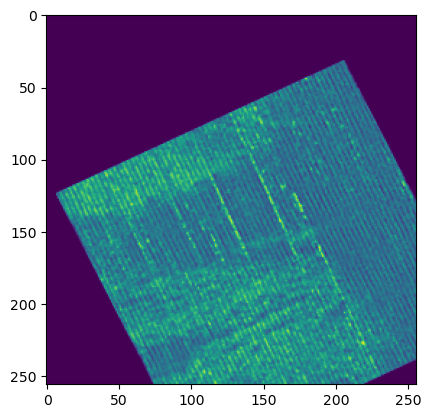

In [171]:

image = get_image(0,0)
plt.imshow(image)

## Calulating The SDH Features

In [172]:
def compute_SD_histogram(image):
    # Convert the image to grayscale
    gray = image
    
    # Define the parameters for the Sum-Difference histogram
    num_bins = 256
    sum_diff_hist = np.zeros((num_bins, num_bins), dtype=np.float32)
    
    # Compute the Sum-Difference histogram
    rows, cols = gray.shape
    for i in range(1, rows):
        for j in range(1, cols):
            sum_val = int(gray[i, j]) + int(gray[i-1, j-1])
            diff_val = int(gray[i, j]) - int(gray[i-1, j-1])
            if sum_val < num_bins and diff_val < num_bins:
                sum_diff_hist[sum_val, diff_val] += 1
    
    # Normalize the histogram
    sum_diff_hist /= np.sum(sum_diff_hist)
    
    return sum_diff_hist

def compute_texture_features(texture_hist):
    # Compute features from the texture histogram
    energy = np.sum(texture_hist ** 2)  # Energy (Uniformity)
    entropy = -np.sum(texture_hist * np.log(texture_hist + 1e-10))  # Entropy
    contrast = np.sum((np.arange(texture_hist.shape[0]) - np.mean(texture_hist)) ** 2)  # Contrast
    correlation = np.sum((np.arange(texture_hist.shape[0])[:, None] * np.arange(texture_hist.shape[1])) * texture_hist) / (np.sqrt(np.sum(np.arange(texture_hist.shape[0]) ** 2) * np.sum(np.arange(texture_hist.shape[1]) ** 2)))  # Correlation
    dissimilarity = np.sum(np.abs(np.arange(texture_hist.shape[0]) - np.mean(texture_hist)))  # Dissimilarity
    
    # Return the texture features as a NumPy array
    return np.array([energy, entropy, contrast, dissimilarity])

def compute_texture_features_from_image(image):
    # Compute Sum-Difference histogram
    texture_hist = compute_SD_histogram(image)
    
    # Compute texture features from the histogram
    texture_features = compute_texture_features(texture_hist)
    
    return texture_features

In [173]:
compute_texture_features_from_image(get_image(1,5))

C:\Users\Akshat Kumar\AppData\Local\Temp\ipykernel_40572\2599365590.py:28: RuntimeWarning: overflow encountered in scalar multiply
  correlation = np.sum((np.arange(texture_hist.shape[0])[:, None] * np.arange(texture_hist.shape[1])) * texture_hist) / (np.sqrt(np.sum(np.arange(texture_hist.shape[0]) ** 2) * np.sum(np.arange(texture_hist.shape[1]) ** 2)))  # Correlation
C:\Users\Akshat Kumar\AppData\Local\Temp\ipykernel_40572\2599365590.py:28: RuntimeWarning: invalid value encountered in sqrt
  correlation = np.sum((np.arange(texture_hist.shape[0])[:, None] * np.arange(texture_hist.shape[1])) * texture_hist) / (np.sqrt(np.sum(np.arange(texture_hist.shape[0]) ** 2) * np.sum(np.arange(texture_hist.shape[1]) ** 2)))  # Correlation


array([1.60247181e-02, 6.95539093e+00, 5.55967900e+06, 3.26399961e+04])

## Extracting GLCM and SDH Features from the Images

In [174]:
glcm_dataset = np.zeros((8*500,7))
sdh_dataset = np.zeros((8*500,6))

In [175]:
def Calculate_GLCM_Values(Main_Dataset):
    l = 0
    for k in range(8):
        for i in range(500):
            image = get_image(k,i)
            glcm = calculate_glcm_features(image)
            Main_Dataset[l][0] = k
            Main_Dataset[l][1] = i
            Main_Dataset[l][2] =glcm[0]
            Main_Dataset[l][3] =glcm[1]
            Main_Dataset[l][4] =glcm[2]
            Main_Dataset[l][5] =glcm[3]
            Main_Dataset[l][6] =glcm[4]
            l = l+1
    return Main_Dataset     

In [176]:
glcm_data = Calculate_GLCM_Values(glcm_dataset)

In [177]:
glcm_data.shape

(4000, 7)

In [178]:
def Calulate_SDH_Values(Main_Dataset):
    l = 0
    for k in range(8):
        for i in range(500):
            image = get_image(k,i)
            SDH = compute_texture_features_from_image(image)
            Main_Dataset[l][0] = k
            Main_Dataset[l][1] = i
            Main_Dataset[l][2] =SDH[0]
            Main_Dataset[l][3] =SDH[1]
            Main_Dataset[l][4] =SDH[2]
            Main_Dataset[l][5] =SDH[3]
            l = l+1
    return Main_Dataset

In [179]:
sdh_data = Calulate_SDH_Values(sdh_dataset)
sdh_data.shape

C:\Users\Akshat Kumar\AppData\Local\Temp\ipykernel_40572\2599365590.py:28: RuntimeWarning: overflow encountered in scalar multiply
  correlation = np.sum((np.arange(texture_hist.shape[0])[:, None] * np.arange(texture_hist.shape[1])) * texture_hist) / (np.sqrt(np.sum(np.arange(texture_hist.shape[0]) ** 2) * np.sum(np.arange(texture_hist.shape[1]) ** 2)))  # Correlation
C:\Users\Akshat Kumar\AppData\Local\Temp\ipykernel_40572\2599365590.py:28: RuntimeWarning: invalid value encountered in sqrt
  correlation = np.sum((np.arange(texture_hist.shape[0])[:, None] * np.arange(texture_hist.shape[1])) * texture_hist) / (np.sqrt(np.sum(np.arange(texture_hist.shape[0]) ** 2) * np.sum(np.arange(texture_hist.shape[1]) ** 2)))  # Correlation
C:\Users\Akshat Kumar\AppData\Local\Temp\ipykernel_40572\2599365590.py:19: RuntimeWarning: invalid value encountered in divide
  sum_diff_hist /= np.sum(sum_diff_hist)


(4000, 6)

In [180]:
df_sdh = pd.DataFrame(sdh_data)
df_glcm = pd.DataFrame(glcm_data)

In [181]:
print(sdh_data)
print(sdh_data.shape)

[[0.00000000e+00 0.00000000e+00 2.07403094e-01 5.32685852e+00
  5.55967900e+06 3.26399961e+04]
 [0.00000000e+00 1.00000000e+00 4.37906504e-01 3.29560256e+00
  5.55967900e+06 3.26399961e+04]
 [0.00000000e+00 2.00000000e+00            nan            nan
             nan            nan]
 ...
 [7.00000000e+00 4.97000000e+02 3.23588145e-04 8.28630924e+00
  5.55967900e+06 3.26399961e+04]
 [7.00000000e+00 4.98000000e+02 2.40921266e-02 6.45878410e+00
  5.55967900e+06 3.26399961e+04]
 [7.00000000e+00 4.99000000e+02 3.56090486e-01 2.93331790e+00
  5.55967900e+06 3.26399961e+04]]
(4000, 6)


In [182]:
print(glcm_data)
print(glcm_data.shape)

[[0.00000000e+00 0.00000000e+00 1.25747901e+03 ... 3.89669561e-01
  3.71875814e-01 8.16995299e-01]
 [0.00000000e+00 1.00000000e+00 4.03140646e+03 ... 1.91585482e-01
  1.81011433e-01 6.69142981e-01]
 [0.00000000e+00 2.00000000e+00 2.35414949e+02 ... 8.02369271e-02
  1.87974039e-02 6.43468770e-01]
 ...
 [7.00000000e+00 4.97000000e+02 9.18792467e+02 ... 5.60283380e-02
  9.55924766e-03 7.42722089e-01]
 [7.00000000e+00 4.98000000e+02 4.67062716e+02 ... 2.75248733e-01
  1.38524956e-01 8.31230841e-01]
 [7.00000000e+00 4.99000000e+02 1.14233041e+03 ... 6.07888055e-01
  3.82454677e-01 9.41881218e-01]]
(4000, 7)


In [183]:
# Save df_sdh to CSV
df_sdh.to_csv('df_sdh.csv', index=False)

# Save df_glcm to CSV
df_glcm.to_csv('df_glcm.csv', index=False)


## Creating a Dataset of SDH and GLCM Features

By combining the Sum-Difference Histogram (SDH) and Gray-Level Co-occurrence Matrix (GLCM) features of multiple images, we can create a dataset for various applications.

## Directly Downloading the Dataset

To streamline the process, we have preprocessed the data and uploaded it to Google Drive. You can automatically download the dataset using the following code:

DRIVE: https://drive.google.com/drive/folders/1TWjjQrsCVBKhvx8TEP7pBsZK9zaMsx3i?usp=drive_link

In [184]:
import gdown

# URLs of the CSV files
df_glcm_url = 'https://drive.google.com/uc?id=1c7Z8AQxzM-wramvXkDlri7pGbPGDOgPM'
df_sdh_url = 'https://drive.google.com/uc?id=1ewOpQlVBNdSc1ipeUtNGidtMjCxQ8_uz'

# Path to save the downloaded files
df_glcm_path = 'df_glcm.csv'
df_sdh_path = 'df_sdh.csv'

# Download df_glcm.csv
gdown.download(df_glcm_url, df_glcm_path, quiet=False)

# Download df_sdh.csv
gdown.download(df_sdh_url, df_sdh_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1c7Z8AQxzM-wramvXkDlri7pGbPGDOgPM
To: C:\Users\Akshat Kumar\OneDrive - Indian Institute of Technology Bombay\Desktop\Final_Dataset\df_glcm.csv
100%|███████████████████████████████████████████████████████████████████████████████| 425k/425k [00:00<00:00, 2.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ewOpQlVBNdSc1ipeUtNGidtMjCxQ8_uz
To: C:\Users\Akshat Kumar\OneDrive - Indian Institute of Technology Bombay\Desktop\Final_Dataset\df_sdh.csv
100%|███████████████████████████████████████████████████████████████████████████████| 338k/338k [00:00<00:00, 1.83MB/s]


'df_sdh.csv'

# Data Preprocessing 

In [185]:
df_glcm = pd.read_csv('df_glcm.csv')
df_sdh = pd.read_csv('df_sdh.csv')

In [186]:
df_sdh

,0,1,2,3,4,5
0,0.0,0.0,0.207403,5.326859,5.559679e+06,32639.996124
1,0.0,1.0,0.437907,3.295603,5.559679e+06,32639.996124
2,0.0,2.0,NaN,NaN,NaN,NaN
3,0.0,3.0,0.000107,9.315405,5.559679e+06,32639.996124
4,0.0,4.0,0.147737,5.780576,5.559679e+06,32639.996124
...,...,...,...,...,...,...
3995,7.0,495.0,0.078727,4.849967,5.559679e+06,32639.996124
3996,7.0,496.0,0.000980,7.609578,5.559679e+06,32639.996124
3997,7.0,497.0,0.000324,8.286309,5.559679e+06,32639.996124
3998,7.0,498.0,0.024092,6.458784,5.559679e+06,32639.996124


In [187]:
df_glcm

,0,1,2,3,4,5,6
0,0.0,0.0,1257.479012,21.652775,0.389670,0.371876,0.816995
1,0.0,1.0,4031.406455,47.749837,0.191585,0.181011,0.669143
2,0.0,2.0,235.414949,12.289545,0.080237,0.018797,0.643469
3,0.0,3.0,5517.928338,56.809831,0.021661,0.007168,0.057997
4,0.0,4.0,983.517370,20.349332,0.276635,0.245534,0.858519
...,...,...,...,...,...,...,...
3995,7.0,495.0,405.169200,10.543858,0.266683,0.091228,0.903584
3996,7.0,496.0,1173.676209,22.081883,0.121974,0.019695,0.475345
3997,7.0,497.0,918.792467,22.198483,0.056028,0.009559,0.742722
3998,7.0,498.0,467.062716,12.126311,0.275249,0.138525,0.831231


In [188]:
# Shuffle the rows of df_glcm
df_glcm = df_glcm.sample(frac=1).reset_index(drop=True)

# Shuffle the rows of df_sdh
df_sdh = df_sdh.sample(frac=1).reset_index(drop=True)

In [189]:
df_glcm

,0,1,2,3,4,5,6
0,6.0,159.0,4711.205136,37.087709,0.342822,0.172364,0.707545
1,7.0,366.0,676.251395,12.176216,0.286302,0.143756,0.878866
2,1.0,170.0,338.164753,9.480466,0.218507,0.093203,0.917931
3,0.0,317.0,1392.001719,17.005012,0.255213,0.205579,0.922465
4,3.0,235.0,2271.108822,26.124404,0.406029,0.353699,0.770258
...,...,...,...,...,...,...,...
3995,3.0,280.0,4426.785672,34.199198,0.422833,0.267054,0.803790
3996,7.0,458.0,834.150601,15.875355,0.271251,0.129824,0.870898
3997,0.0,344.0,548.905371,16.885508,0.075925,0.019888,0.458963
3998,6.0,420.0,3099.208166,31.372078,0.365430,0.146149,0.684547


In [190]:
ground_truth_glcm = df_glcm.iloc[:,0]
ground_truth_sdh = df_sdh.iloc[:,0]

In [191]:
ground_truth_glcm

0       6.0
1       7.0
2       1.0
3       0.0
4       3.0
       ... 
3995    3.0
3996    7.0
3997    0.0
3998    6.0
3999    7.0
Name: 0, Length: 4000, dtype: float64

In [192]:
# Drop the first and second columns by index from df_glcm
df_glcm = df_glcm.drop(df_glcm.columns[[0, 1]], axis=1)

# Drop the first and second columns by index from df_sdh
df_sdh = df_sdh.drop(df_sdh.columns[[0, 1]], axis=1)


# Visualizing The Data

In [193]:
df_shuffled_glcm = df_glcm
df_shuffled_sdh = df_sdh

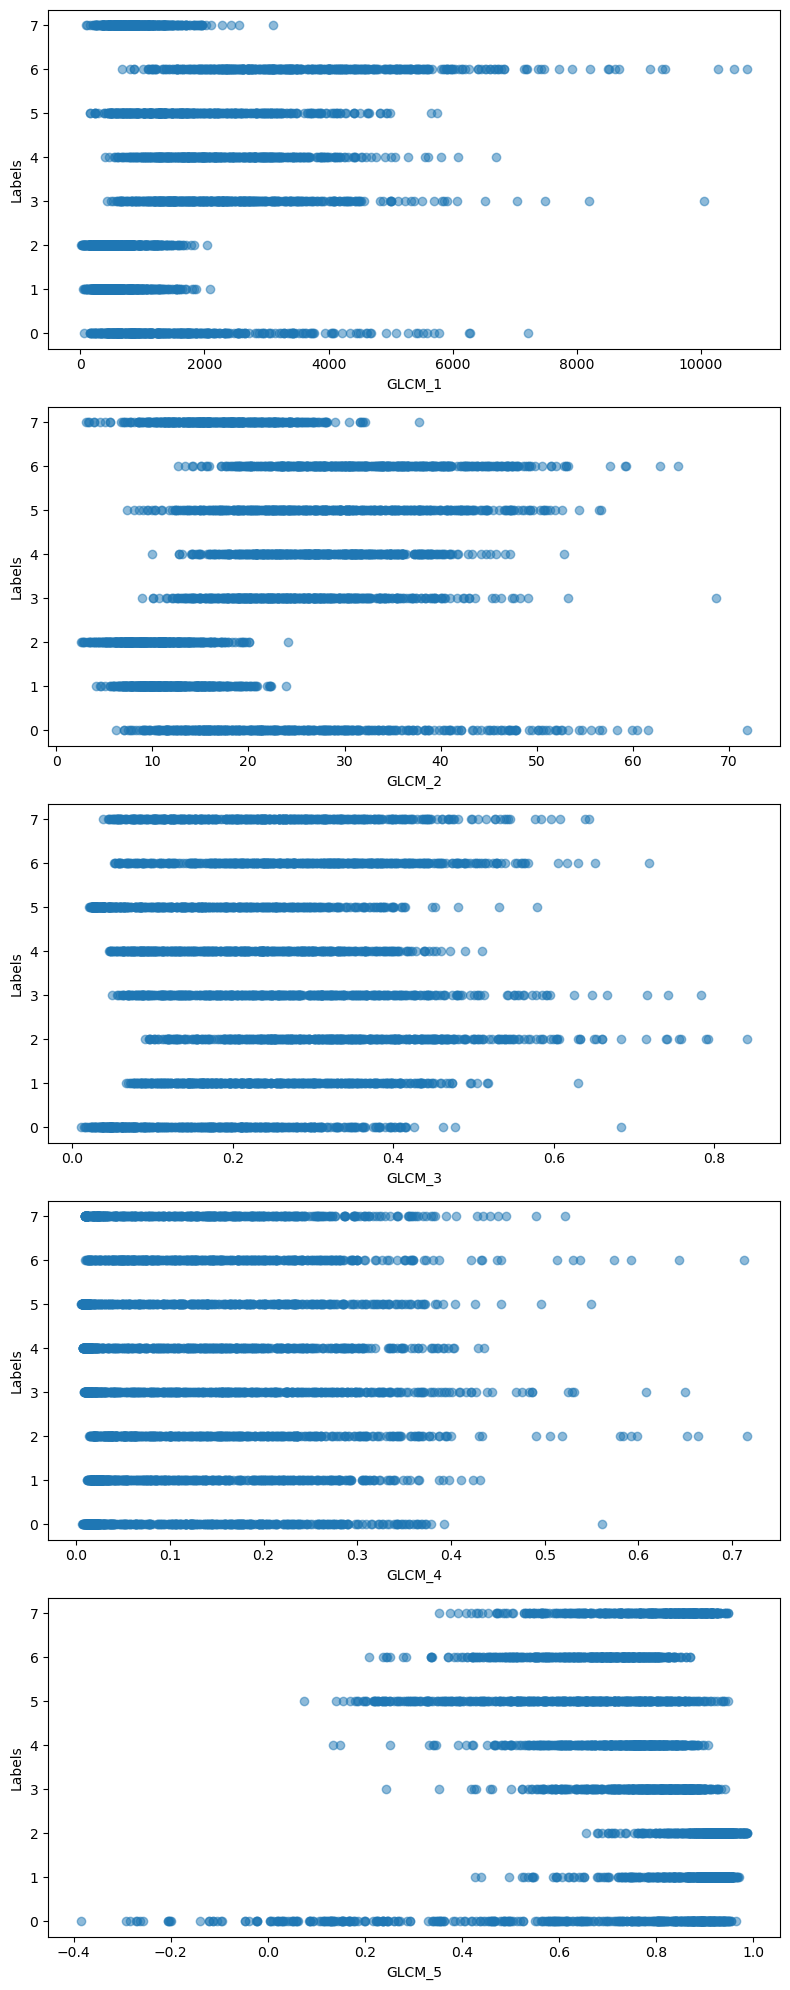

In [194]:
GLCM_features = ['GLCM_1', 'GLCM_2', 'GLCM_3', 'GLCM_4', 'GLCM_5']
df_shuffled_glcm.columns = GLCM_features
# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Plot each GLCM feature against labels
for i, feature in enumerate(GLCM_features):
    axs[i].scatter(df_shuffled_glcm[feature], ground_truth_glcm, alpha=0.5)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Labels')

plt.tight_layout()
plt.show()

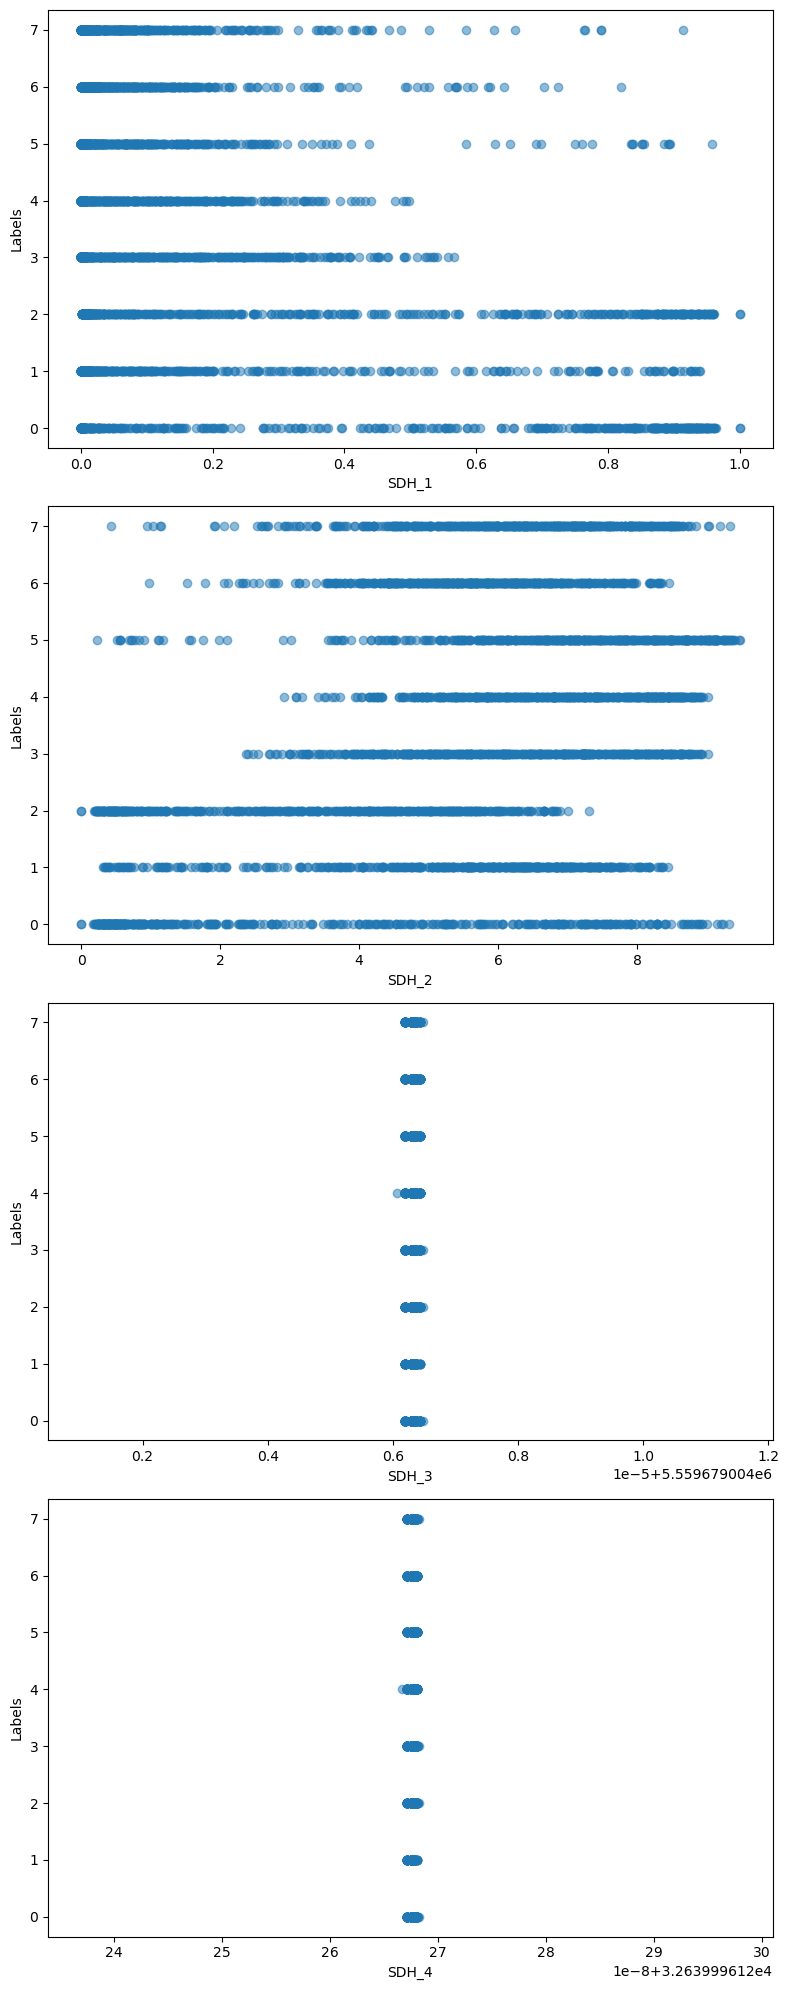

In [195]:
SDH_features = ['SDH_1', 'SDH_2', 'SDH_3', 'SDH_4']

df_shuffled_sdh.columns = SDH_features

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 20))

# Plot each GLCM feature against labels
for i, feature in enumerate(SDH_features):
    axs[i].scatter(df_shuffled_sdh[feature], ground_truth_sdh, alpha=0.5)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Labels')

plt.tight_layout()
plt.show()

## Normalizing The Data

In [196]:
glcm_d = df_shuffled_glcm.values
sdh_d = df_shuffled_sdh.values

In [197]:

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
glcm_data = scaler.fit_transform(glcm_d)
sdh_data = scaler.fit_transform(sdh_d)


# Creating ML Models For GLCM 

In [204]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# Define the input shape
input_shape = (glcm_data.shape[1],)

# Create the model
glcm_model = Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming you're doing binary classification
])

# Compile the model with modified settings
learning_rate = 0.1  # Increased learning rate
loss_type = 'mean_squared_error'  # Changed loss function to mean squared error
optimizer = SGD(learning_rate=learning_rate)  # Changed optimizer to SGD with specified learning rate

glcm_model.compile(optimizer=optimizer, loss=loss_type, metrics=['accuracy'])

# Train the model
glcm_model.fit(glcm_data, ground_truth_glcm, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30


C:\Users\Akshat Kumar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1251 - loss: 11.7189 - val_accuracy: 0.1250 - val_loss: 11.6734
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1193 - loss: 11.2073 - val_accuracy: 0.1250 - val_loss: 11.6699
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1290 - loss: 11.4279 - val_accuracy: 0.1250 - val_loss: 11.6689
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1233 - loss: 11.3935 - val_accuracy: 0.1250 - val_loss: 11.6685
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1276 - loss: 11.2664 - val_accuracy: 0.1250 - val_loss: 11.6682
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1186 - loss: 11.2701 - val_accuracy: 0.1250 - val_loss: 11.6681
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1239 - loss: 11.6286 - val_accuracy: 0.1250 - val_loss: 11.6680
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1263 - loss: 11.3052 - val_accuracy

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(glcm_data, ground_truth_glcm, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.62125


# Creating ML Models For SDH

In [200]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(sdh_data, ground_truth_sdh, test_size=0.2, random_state=42)

# Step 2: Preprocess the data (if necessary)

# Step 3: Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),  # Corrected input shape to match the number of features
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  # 8 classes, so the output layer has 8 units and softmax activation
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)  # Adjust epochs and batch_size as needed

# Step 6: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/10


C:\Users\Akshat Kumar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1356 - loss: 2.0762 - val_accuracy: 0.1187 - val_loss: 2.0796
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1274 - loss: 2.0794 - val_accuracy: 0.1187 - val_loss: 2.0798
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1233 - loss: 2.0795 - val_accuracy: 0.1187 - val_loss: 2.0797
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1313 - loss: 2.0794 - val_accuracy: 0.1187 - val_loss: 2.0800
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1394 - loss: 2.0790 - val_accuracy: 0.1187 - val_loss: 2.0801
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1262 - loss: 2.0796 - val_accuracy: 0.1187 - val_loss: 2.0800
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1301 - loss: 2.0795 - val_accuracy: 0.1187 - val_loss: 2.0801
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.0796 - val_accuracy: 0.1187 - val_loss: 2.0802
Epo

In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)
